# Microbiome machine learning analysis

## Setup

### Import the calour module

In [1]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from calour.training import plot_scatter, plot_roc, plot_cm

In [2]:
import calour as ca

In [3]:
%matplotlib notebook

## Regression 

### Loading the data

We will use the data from Qitta study 103 (https://qiita.ucsd.edu/study/description/103#)

In [4]:
dat=ca.read_amplicon('data/88-soil.biom',
                     'data/88-soil.sample.txt',
                     normalize=100,min_reads=10)

2020-09-14 16:22:13 WARNING Do you forget to normalize your data? It is required before running this function


In [5]:
print(dat)

AmpliconExperiment with 88 samples, 7396 features


### Process the data

#### Get rid of the features (bacteria) with small amount of reads
We throw away all features with total reads (over all samples) < 1 (after each sample was normalized to 100 reads/sample). Note alternatively we could filter based on mean reads/sample or fraction of samples where the feature is present. Each method filters away slightly different bacteria. See **filtering** notebook for details on the filtering functions.

In [6]:
dat=dat.filter_sum_abundance(1)
dat

AmpliconExperiment with 88 samples, 1756 features

#### Use soil microbiome to predict its pH

Let's look at the distribution of pH for all the samples:

<IPython.core.display.Javascript object>


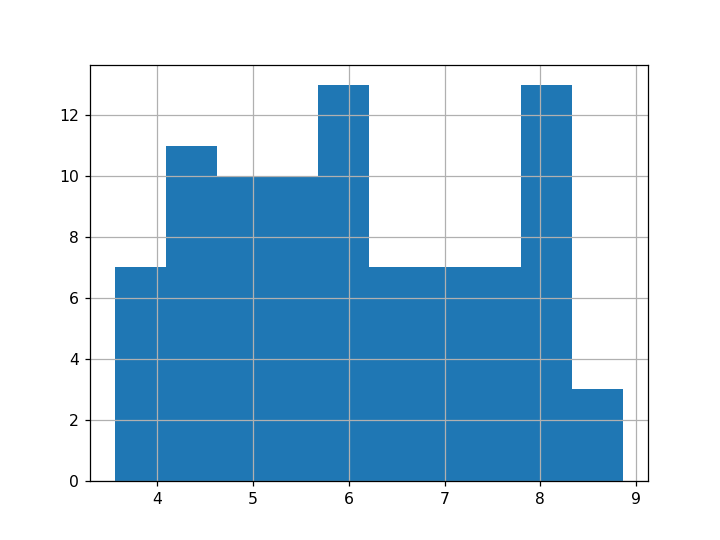

<AxesSubplot:>

In [7]:
dat.sample_metadata['ph'].hist()

<IPython.core.display.Javascript object>


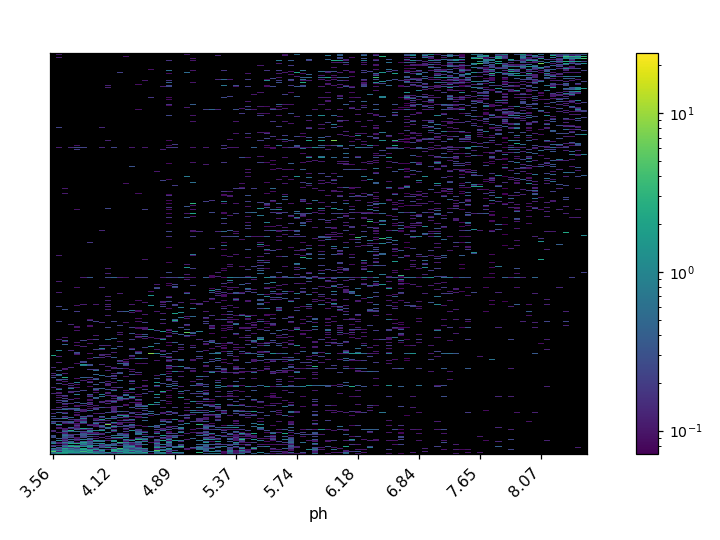

/beegfs/git/calour/calour/heatmap/heatmap.py:309: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  cmap.set_bad(bad_color)


Label(value='0 features are selected')

HTML(value='no annotation found', layout=Layout(height='100px', overflow_y='auto'))

In [8]:
dat.sort_samples('ph').sort_centroid(n=0.001).plot(sample_field='ph', gui='jupyter')

We can then run regression analysis:

In [9]:
it = dat.regress('ph', RandomForestRegressor(random_state=0), cv=5, params=[{'n_estimators':3}, {'n_estimators': 500}])

This function returns a generator, which yields the prediction result for each parameter set specified in `params`. Here we would like to see how the number of trees (named `n_estimators`) in the model impact its performance. The result with `n_estimators = 10` is:

In [10]:
res1 = next(it)

In [11]:
res1.head()

,Y_PRED,Y_TRUE,SAMPLE,CV
0,7.746667,8.02,103.CA2,0
1,7.143333,6.02,103.CO3,0
2,7.350000,6.95,103.SR3,0
3,5.876667,5.52,103.IE2,0
4,6.543333,7.53,103.BP1,0


We can plot out the result as following. Each dot is a sample with observed and predicted pH, colored by the fold of cross validation the sample is from. The diagonal line indicates perfect predition. The correlation coefficient and its p-value between the prediction and observation are also annotated around the top of the plot.

<IPython.core.display.Javascript object>


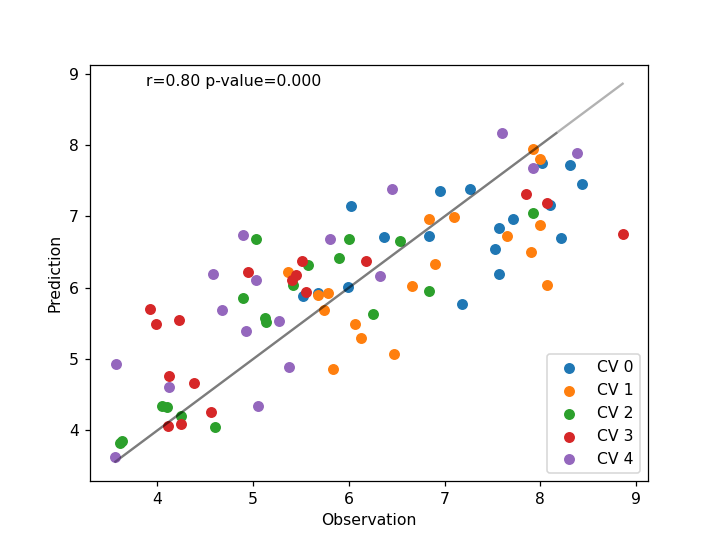

<AxesSubplot:xlabel='Observation', ylabel='Prediction'>

In [12]:
plot_scatter(res1, cv=True)

Let's look at the result for `n_estimators = 500`:

In [13]:
res2 = next(it)

In [14]:
res2.head()

,Y_PRED,Y_TRUE,SAMPLE,CV
0,7.02082,8.02,103.CA2,0
1,6.36854,6.02,103.CO3,0
2,7.51280,6.95,103.SR3,0
3,5.57770,5.52,103.IE2,0
4,7.05552,7.53,103.BP1,0


<IPython.core.display.Javascript object>


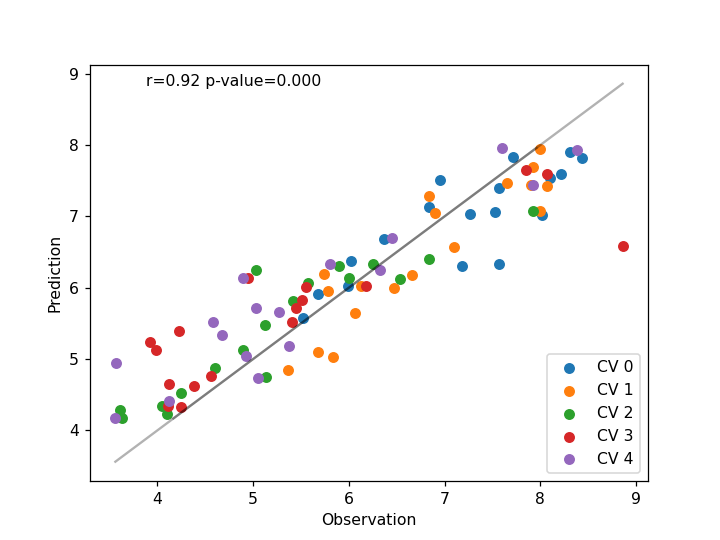

<AxesSubplot:xlabel='Observation', ylabel='Prediction'>

In [15]:
plot_scatter(res2, cv=True)

From the plot, you can see, with more trees in the Random Forest model, the prediction is much better with a higher correlation coefficient.

## Classification

We can do analysis similarly for classification. Let's show it with another data set that was introduced in previous notebook.

In [16]:
dat=ca.read_amplicon('data/chronic-fatigue-syndrome.biom',
                     'data/chronic-fatigue-syndrome.sample.txt',
                     normalize=10000,min_reads=1000)

2020-09-14 16:22:39 WARNING These have metadata but do not have data - dropped (1): {'ERR1331814'}
2020-09-14 16:22:39 WARNING Do you forget to normalize your data? It is required before running this function


In [17]:
print(dat)

AmpliconExperiment with 87 samples, 2129 features


Let's see if we can distinguish patient samples from control samples with classification:

In [18]:
dat.sample_metadata['Subject'].value_counts()

Patient    48
Control    39
Name: Subject, dtype: int64

In [19]:
it = dat.classify('Subject', RandomForestClassifier(random_state=0), cv=RepeatedStratifiedKFold(5, 3), params=[{'n_estimators':3}, {'n_estimators': 500}])

/beegfs/software/miniconda3/envs/calour/lib/python3.8/site-packages/sklearn/utils/validation.py:68: FutureWarning: Pass n_splits=5, n_repeats=3 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


In [20]:
res1 = next(it)

In [21]:
res1.head()

,Control,Patient,Y_TRUE,SAMPLE,CV
0,0.333333,0.666667,Control,ERR1331831,0
1,0.333333,0.666667,Patient,ERR1331815,0
2,0.000000,1.000000,Patient,ERR1331804,0
3,0.666667,0.333333,Patient,ERR1331803,0
4,0.000000,1.000000,Patient,ERR1331866,0


We can plot out the result as ROC curve or confusion matrix.

<IPython.core.display.Javascript object>


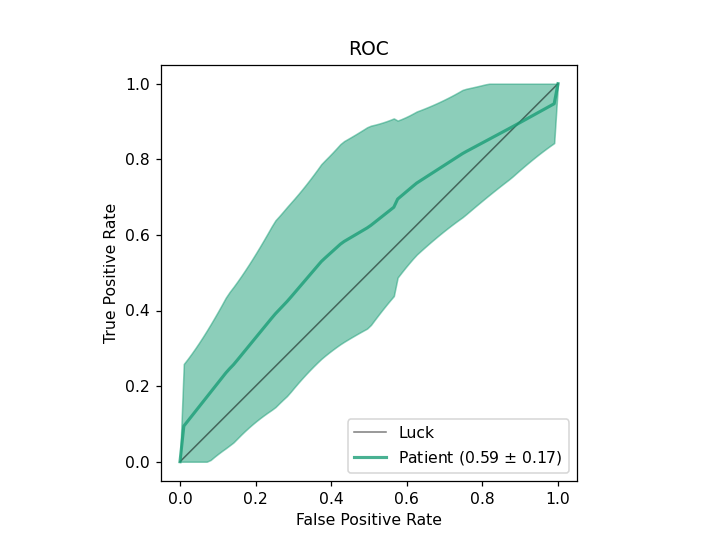

(<AxesSubplot:title={'center':'ROC'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>,
 0.5916634281460318)

In [22]:
plot_roc(res1, classes=['Patient'])

You can also plot confustion matrix:

<IPython.core.display.Javascript object>


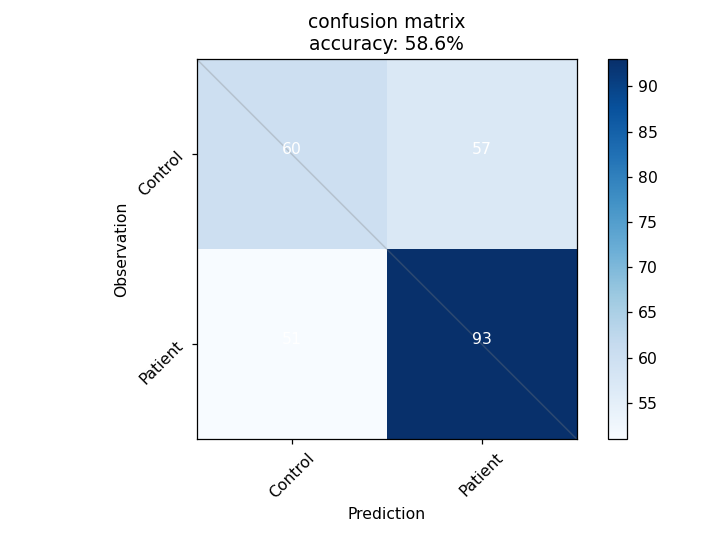

<AxesSubplot:title={'center':'confusion matrix\naccuracy: 58.6%'}, xlabel='Prediction', ylabel='Observation'>

In [23]:
plot_cm(res1)

Let's look at the result for `n_estimators = 500`:

In [24]:
res2 = next(it)

In [25]:
res2.head()

,Control,Patient,Y_TRUE,SAMPLE,CV
0,0.190,0.810,Patient,ERR1331791,0
1,0.358,0.642,Patient,ERR1331803,0
2,0.396,0.604,Control,ERR1331827,0
3,0.502,0.498,Patient,ERR1331797,0
4,0.254,0.746,Patient,ERR1331839,0


<IPython.core.display.Javascript object>


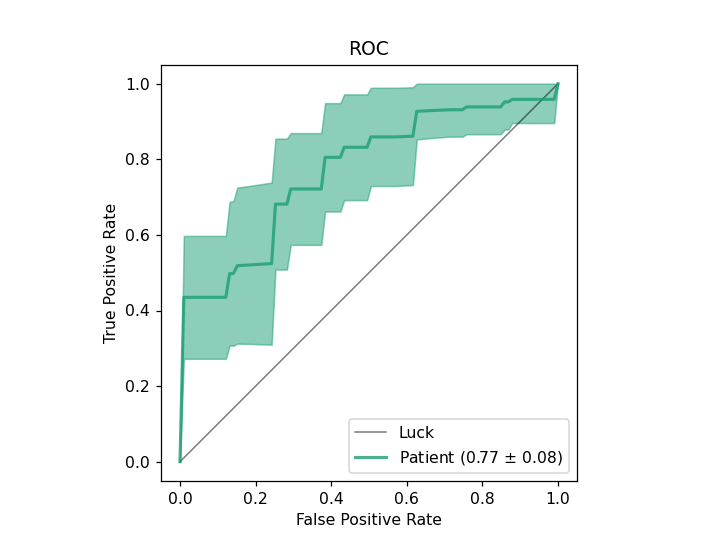

(<AxesSubplot:title={'center':'ROC'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>,
 0.7695631964992236)

In [26]:
plot_roc(res2, classes=['Patient'])

You can also plot confustion matrix:

<IPython.core.display.Javascript object>


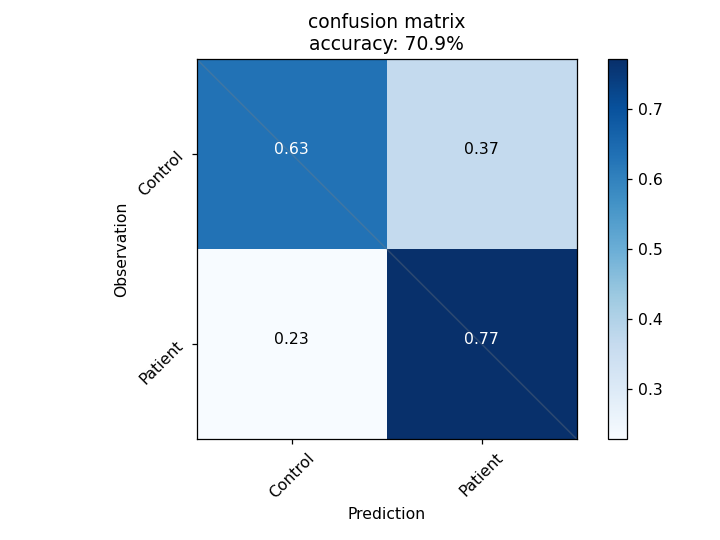

<AxesSubplot:title={'center':'confusion matrix\naccuracy: 70.9%'}, xlabel='Prediction', ylabel='Observation'>

In [27]:
plot_cm(res2, normalize=True)

From the confusion matrix and ROC plots, you can see, with more trees in the Random Forest model, similar to regression, the classification accuracy is much better.